# Homework 5 - Yelp Data Analysis

In this notebook, we will work on two tasks. 
1. Predicting restaurant's rating 
2. Predicting Whether an Establishment has shut down

In [107]:
### John Bruno 
import pandas as pd
from collections import Counter
import numpy as np
import ast
# reference: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
# pip install imblearn


import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from pdpbox.pdp import pdp_isolate, pdp_plot

%matplotlib inline

## Part I. Data Exploration

The first step in performing a succesfull analysis is properly exploring our data. Below I have started by using pandas built in info() function to get some stats about all of the metrics in our data.

In [108]:
df_union = pd.read_csv("Data/business_unfold.csv", low_memory=False)
print(df_union.shape)

ParserError: Error tokenizing data. C error: out of memory

In [ ]:
# select columns with less than 75% of missing values

columns = df_union.columns
marked_for_removal = []
good_to_keep = []
for column in columns:
    temp = df_union[column]
    temp_describe = temp.isnull().describe()
    if temp_describe['top'] == True and temp_describe['freq'] > (temp_describe['count']*.75):
        marked_for_removal.append(column)
    else:
        good_to_keep.append(column)
        print(column + " is good to keep! Less than 75% of its values are null-objects.")
print('('+ str(len(good_to_keep)) + ') columns are good to keep')
print('\n\n')
for column in marked_for_removal:
    print(column + " is marked for removal")
print('('+ str(len(marked_for_removal)) + ') columns have been marked for removal')
    

The columns that have been marked for removal must now be removed from the data

In [109]:
#dropping the columns that have been marked for removal
df = df_union.drop(marked_for_removal, axis=1)
for i in list(df.columns):
    print(i)

Unnamed: 0
address
business_id
categories
city
hours
is_open
latitude
longitude
name
postal_code
review_count
stars
state
businessID
Alcohol
BikeParking
BusinessAcceptsCreditCards
BusinessParking
GoodForKids
OutdoorSeating
RestaurantsAttire
RestaurantsDelivery
RestaurantsGoodForGroups
RestaurantsPriceRange2
RestaurantsReservations
RestaurantsTakeOut
WiFi


In [110]:
# from the above list, only keep the columns you are interested.

# latitude: a geographic coordinate that specifies the north–south position of a point on the Earth's surface
# longitude: a geographic coordinate that specifies the east–west position of a point on the Earth's surface
# review_count: the total number of reviews made on a business
# stars: the avg star rating for a business
# RestaurantsPriceRange2: the price range of a business ranging from 1-4
# HasBikeParking: binary variable denoting whether a restaurant has bike parking or not
# AcceptsCreditCards: a binary variable denoting whether a restaurant accepts credit cards or not

keeplist = ['is_open','latitude','longitude','review_count','stars','Alcohol','BikeParking','BusinessAcceptsCreditCards','OutdoorSeating','GoodForKids']
df = df[keeplist].dropna()

In [111]:
# print the information of the dataset
print(df.info())

# print # of rows, # of columns
print(df.shape)

# print the first five rows
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22970 entries, 2 to 192603
Data columns (total 10 columns):
is_open                       22970 non-null int64
latitude                      22970 non-null float64
longitude                     22970 non-null float64
review_count                  22970 non-null int64
stars                         22970 non-null float64
Alcohol                       22970 non-null object
BikeParking                   22970 non-null object
BusinessAcceptsCreditCards    22970 non-null object
OutdoorSeating                22970 non-null object
GoodForKids                   22970 non-null object
dtypes: float64(3), int64(2), object(5)
memory usage: 1.5+ MB
None
(22970, 10)


,is_open,latitude,longitude,review_count,stars,Alcohol,BikeParking,BusinessAcceptsCreditCards,OutdoorSeating,GoodForKids
2,1,35.092564,-80.859132,170,4.0,u'beer_and_wine',True,True,False,True
12,1,35.527410,-80.868003,9,3.5,'beer_and_wine',True,True,True,False
13,1,41.708520,-81.359556,16,4.0,u'none',True,True,False,True
22,1,36.080168,-115.182756,107,4.0,u'full_bar',False,True,True,False
25,1,36.195615,-115.040529,184,4.5,u'beer_and_wine',True,True,False,True


# Part II. Data Cleansing

Here we will convert text variables to numeric variable variables

### Clean up the 'Alcohol' column

In [112]:
df['Alcohol'].value_counts()

u'none'             7626
u'full_bar'         6788
'none'              3475
u'beer_and_wine'    2183
'full_bar'          1873
'beer_and_wine'     1006
None                  19
Name: Alcohol, dtype: int64

In [113]:
df.loc[df["Alcohol"] == "u'none'", "Alcohol"] = 0 
df.loc[df["Alcohol"] == "'none'", "Alcohol"] = 0
df.loc[df["Alcohol"] == "None", "Alcohol"] = 0

df.loc[df["Alcohol"] == "u'beer_and_wine'", "Alcohol"] = 1
df.loc[df["Alcohol"] == "'beer_and_wine'", "Alcohol"] = 1

df.loc[df["Alcohol"] == "u'full_bar'", "Alcohol"] = 2

df.loc[df["Alcohol"] == "'full_bar'", "Alcohol"] = 2

In [114]:
df['Alcohol'] = df['Alcohol'].astype(int)
df['Alcohol'].value_counts()

0    11120
2     8661
1     3189
Name: Alcohol, dtype: int64

### Clean up other columns

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22970 entries, 2 to 192603
Data columns (total 10 columns):
is_open                       22970 non-null int64
latitude                      22970 non-null float64
longitude                     22970 non-null float64
review_count                  22970 non-null int64
stars                         22970 non-null float64
Alcohol                       22970 non-null int32
BikeParking                   22970 non-null object
BusinessAcceptsCreditCards    22970 non-null object
OutdoorSeating                22970 non-null object
GoodForKids                   22970 non-null object
dtypes: float64(3), int32(1), int64(2), object(4)
memory usage: 1.5+ MB


In [116]:
# BikeParking
df['BikeParking'].value_counts()

True     17501
False     5447
None        22
Name: BikeParking, dtype: int64

In [117]:
df.loc[df["BikeParking"] == "True", "BikeParking"] = 1 
df.loc[df["BikeParking"] == "False", "BikeParking"] = 0
df.loc[df["BikeParking"] == "None", "BikeParking"] = 0

df['BikeParking'] = df['BikeParking'].astype(int)
df['BikeParking'].value_counts()

1    17501
0     5469
Name: BikeParking, dtype: int64

In [118]:
# BusinessAcceptsCreditCards
df['BusinessAcceptsCreditCards'].value_counts()

True     22489
False      466
None        15
Name: BusinessAcceptsCreditCards, dtype: int64

In [119]:
df.loc[df["BusinessAcceptsCreditCards"] == "True", "BusinessAcceptsCreditCards"] = 1 
df.loc[df["BusinessAcceptsCreditCards"] == "False", "BusinessAcceptsCreditCards"] = 0
df.loc[df["BusinessAcceptsCreditCards"] == "None", "BusinessAcceptsCreditCards"] = 0

df['BusinessAcceptsCreditCards'] = df['BusinessAcceptsCreditCards'].astype(int)
df['BusinessAcceptsCreditCards'].value_counts()

1    22489
0      481
Name: BusinessAcceptsCreditCards, dtype: int64

In [120]:
# Task #1: change non-numeric values in the columns of 'OutdoorSeating','GoodForKids' to numeric values

df['OutdoorSeating'].value_counts()

False    12793
True     10160
None        17
Name: OutdoorSeating, dtype: int64

In [121]:
df.loc[df["OutdoorSeating"] == "True", "OutdoorSeating"] = 1 
df.loc[df["OutdoorSeating"] == "False", "OutdoorSeating"] = 0
df.loc[df["OutdoorSeating"] == "None", "OutdoorSeating"] = 0

df['OutdoorSeating'] = df['OutdoorSeating'].astype(int)
df['OutdoorSeating'].value_counts()

0    12810
1    10160
Name: OutdoorSeating, dtype: int64

In [122]:
df['GoodForKids'].value_counts()

True     19297
False     3668
None         5
Name: GoodForKids, dtype: int64

In [123]:
df.loc[df["GoodForKids"] == "True", "GoodForKids"] = 1 
df.loc[df["GoodForKids"] == "False", "GoodForKids"] = 0
df.loc[df["GoodForKids"] == "None", "GoodForKids"] = 0

df['GoodForKids'] = df['GoodForKids'].astype(int)
df['GoodForKids'].value_counts()

1    19297
0     3673
Name: GoodForKids, dtype: int64

In [124]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22970 entries, 2 to 192603
Data columns (total 10 columns):
is_open                       22970 non-null int64
latitude                      22970 non-null float64
longitude                     22970 non-null float64
review_count                  22970 non-null int64
stars                         22970 non-null float64
Alcohol                       22970 non-null int32
BikeParking                   22970 non-null int32
BusinessAcceptsCreditCards    22970 non-null int32
OutdoorSeating                22970 non-null int32
GoodForKids                   22970 non-null int32
dtypes: float64(3), int32(5), int64(2)
memory usage: 1.5 MB
None


## Part III. Model 1_Predictive Restaurant’s Rating (Regression)

In [125]:
x_columns = ['latitude','longitude','review_count','Alcohol','BikeParking','BusinessAcceptsCreditCards','OutdoorSeating','GoodForKids']
# plot the distribution of 'stars'

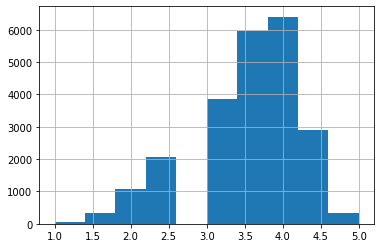

In [126]:
df['stars'].hist()

# if the distribution is too skewed, you might want to log-transform 'stars'.
# df['stars'] = np.log(df['stars'])

In [127]:
# split the dataset to train and test
X = df[x_columns]
y = df['stars']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 3)

In [128]:
# Task #2: build a Random Forest Regressor model
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=10)
forest_reg.fit(X_train, y_train)

y_pred_forest = forest_reg.predict(X_test)




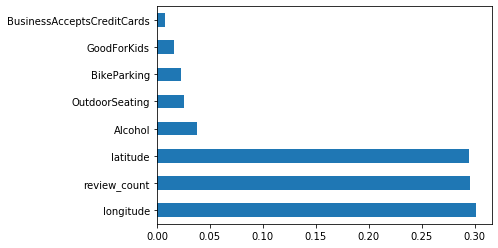

In [129]:
# Task #3: plot the features importance scores
feat_importances = pd.Series(forest_reg.feature_importances_, index=X.columns)
feat_importances.nlargest(8).plot(kind='barh')



In [130]:
# Task #4: create three pdpbox plots to explain the impact of 'review_count', 'Alcohol' on 'stars' separately.
# Also, interpret the pdpbox plots.

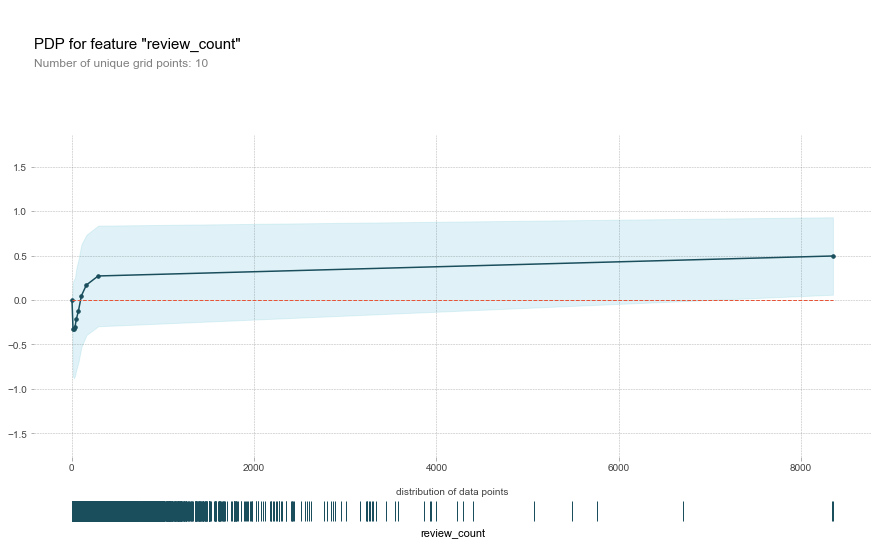

In [131]:
pdp_TimeFirst = pdp_isolate(model=forest_reg, dataset=df, model_features=x_columns,feature='review_count')
fig, axes = pdp_plot(pdp_isolate_out=pdp_TimeFirst,feature_name='review_count',plot_pts_dist=True)


In [132]:
# review_count: amount of reviews 
    
# Interpretation; When the amount of reviews is more, the higher the chance of that resturaunt being rated higher,
# except when low review count.


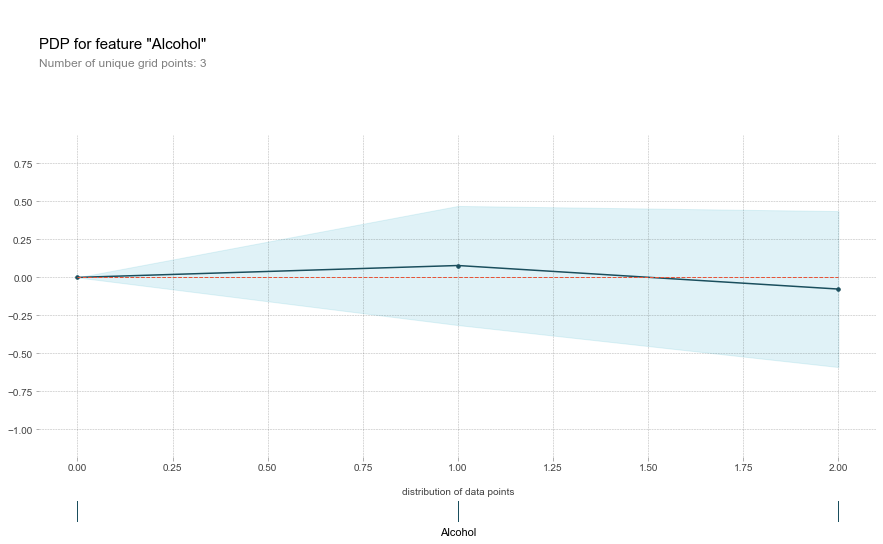

In [133]:
pdp_TimeFirst = pdp_isolate(model=forest_reg, dataset=df, model_features=x_columns,feature='Alcohol')
fig, axes = pdp_plot(pdp_isolate_out=pdp_TimeFirst,feature_name='Alcohol',plot_pts_dist=True)

In [ ]:
# Alchohol: categorizes restuaraunts based on how they sell alcohol
df.loc[df["Alcohol"] == "u'none'", "Alcohol"] = 0 
df.loc[df["Alcohol"] == "'none'", "Alcohol"] = 0
df.loc[df["Alcohol"] == "None", "Alcohol"] = 0

df.loc[df["Alcohol"] == "u'beer_and_wine'", "Alcohol"] = 1
df.loc[df["Alcohol"] == "'beer_and_wine'", "Alcohol"] = 1

df.loc[df["Alcohol"] == "u'full_bar'", "Alcohol"] = 2

df.loc[df["Alcohol"] == "'full_bar'", "Alcohol"] = 2

# 0 = none, 1 = beer/wine, 2 = full bar    
# Interpretation; When the aresturaunt has none, higher chance rating isn't impacted, however when they sell beer and wine, 
# higher chance it improves rating slightly and when it's a full bar the higher the chance the rating decreases slightly.

In [97]:
# Task #5: Measure model performance using RMSE
from sklearn.metrics import mean_squared_error
forest_mse = mean_squared_error(y_pred_forest, y_test)
forest_rmse = np.sqrt(forest_mse)
print('Random Forest RMSE: %.4f' % forest_rmse)


Random Forest RMSE: 0.6858


## Part IV. Model 2_Predictive Restaurant’s Longevity (Classification)

In this part, we will build up a classification model, in which 'is_open' is the dependent variable (y).

1    18634
0     4336
Name: is_open, dtype: int64

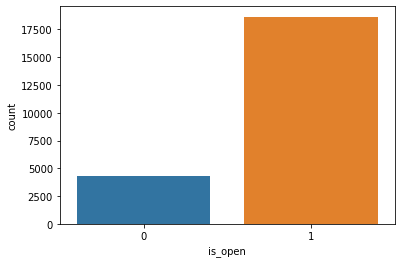

In [98]:
# Plot the distribution of the y variable
sns.countplot(df.is_open, label="Count")
df['is_open'].value_counts()

In [99]:
x_columns = ['latitude','longitude','review_count','stars','Alcohol','BikeParking','BusinessAcceptsCreditCards','OutdoorSeating','GoodForKids']

In [100]:
# SMOTE: Synthetic Minority Oversampling Technique (synthesize new examples from the minority class)
from imblearn.over_sampling import (SMOTE)

sampler = SMOTE(sampling_strategy = 1)
X_rs, y_rs = sampler.fit_sample(df[x_columns], df['is_open'])
print('SMOTE {}'.format(Counter(y_rs)))

X=pd.DataFrame(X_rs, columns=x_columns)
y = pd.DataFrame(y_rs, columns = ['is_open'])

# combine the columns in X and y
df_new = pd.concat([X, y], axis=1)

SMOTE Counter({1: 18634, 0: 18634})


1    18634
0    18634
Name: is_open, dtype: int64

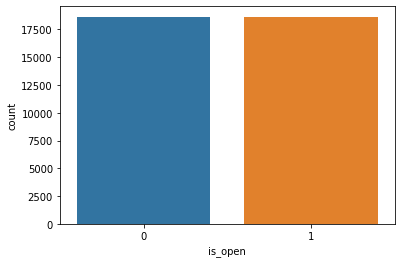

In [101]:
# Plot the distribution of the y variable
sns.countplot(df_new.is_open, label="Count")
df_new['is_open'].value_counts()

In [102]:
# split the dataset for cross validation
X_train, X_test, y_train, y_test = train_test_split\
  (X, y, train_size = 0.6, random_state = 1)

In [ ]:
# Task #6: Create a Random Forest Classifier model 

for i in range(1, 11):
    rfc2 = RandomForestClassifier(max_features=i, random_state=1)
    rfc2.fit(X_train, y_train)
    pred2 = rfc2.predict(X_test)
    print("Accuracy for %s feature(s) equals %s" %(i, accuracy_score(y_test, pred2)))




In [ ]:
# Task #7: plot the features importance scores





In [ ]:
# Task #8: create three pdpbox plots to explain the impact of 'stars', 'review_count', 'Alcohol' on 'is_open' separately.
# Also, interpret the pdpbox plots.